In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
id_cols = ['PUF_CASE_ID', 'YEAR_OF_DIAGNOSIS', 'CLASS_OF_CASE']

fac_cols = [ 'PUF_FACILITY_ID', 'FACILITY_TYPE_CD', 'FACILITY_LOCATION_CD']

dem_cols = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN']

ses_cols = ['INSURANCE_STATUS', 'UR_CD_13', 'CROWFLY', 'NO_HSD_QUAR_2016', 'MED_INC_QUAR_2016', 'PUF_MEDICAID_EXPN_CODE']
 
medco_cols = ['CDCC_TOTAL_BEST']

tumor_cols = ['HISTOLOGY', 'GRADE', 'GRADE_CLIN', 'TUMOR_SIZE', 'TUMOR_SIZE_SUMMARY_2016', 'TNM_CLIN_T', 'TNM_CLIN_N', 'TNM_CLIN_M', 'TNM_CLIN_STAGE_GROUP', 'TNM_PATH_T', 'TNM_PATH_N', 'TNM_PATH_M', 'TNM_PATH_STAGE_GROUP', 'AJCC_TNM_CLIN_T', 'AJCC_TNM_CLIN_N', 'AJCC_TNM_CLIN_M', 'AJCC_TNM_CLIN_STG_GRP', 'AJCC_TNM_PATH_T', 'AJCC_TNM_PATH_N', 'AJCC_TNM_PATH_M', 'AJCC_TNM_PATH_STG_GRP', 'AJCC_TNM_POST_PATH_T',  'AJCC_TNM_POST_PATH_N', 'AJCC_TNM_POST_PATH_M', 'AJCC_TNM_POST_PATH_STG_GRP', 'LYMPH_VASCULAR_INVASION',]

rad_cols = ['RAD_LOCATION_OF_RX','DX_RAD_STARTED_DAYS', 'RAD_ELAPSED_RX_DAYS', 'REASON_FOR_NO_RADIATION', 'TOTAL_DOSE',]

chemo_cols = ['RX_SUMM_CHEMO', 'DX_CHEMO_STARTED_DAYS', 'RX_SUMM_SYSTEMIC_SUR_SEQ']

surg_cols = ['RX_SUMM_SURGRAD_SEQ', 'PALLIATIVE_CARE', 'DX_SURG_STARTED_DAYS', 'DX_DEFSURG_STARTED_DAYS', 'RX_SUMM_SURG_PRIM_SITE', 'RX_SUMM_SURGICAL_MARGINS','SURG_DISCHARGE_DAYS', 'READM_HOSP_30_DAYS', 'REASON_FOR_NO_SURGERY', ]

os_cols = ['DX_LASTCONTACT_DEATH_MONTHS', 'PUF_VITAL_STATUS',]
 
incl = id_cols + fac_cols + dem_cols + ses_cols + medco_cols + tumor_cols + rad_cols + chemo_cols + surg_cols + os_cols

In [10]:
len(incl)

62

In [11]:
data = pd.read_csv('data/ascc.csv', usecols=incl, na_values=[999, 99], low_memory=False)
data.shape

(85027, 62)

In [12]:
data = data[data['CLASS_OF_CASE'] != 0]
data.drop('CLASS_OF_CASE', axis=1, inplace=True)

In [13]:
#define a function that returns value counts and value percentages for a given column
def table(df, col):
    return pd.concat([df[col].value_counts(), df[col].value_counts(normalize=True)], axis=1, keys=('counts', 'percent'))
def perc_APR(df):
    return table(df, 'APR')['percent'][1]

In [14]:
#create a dataframe with the counts and percentages of a variable by year
def by_year(df, col):
    cts = pd.crosstab(df['YEAR_OF_DIAGNOSIS'], df[col])
    percs = pd.crosstab(df['YEAR_OF_DIAGNOSIS'], df[col], normalize='index')
    percs = percs.round(2) * 100
    percs = percs.astype(str)
    cts = cts.astype(str)
    comb = cts + ' (' + percs + '%)'
    comb['total'] = df['YEAR_OF_DIAGNOSIS'].value_counts().sort_index()
    return comb
def by_stage(df, col):
    cts = pd.crosstab(df['stage'], df[col])
    percs = pd.crosstab(df['stage'], df[col], normalize='index')
    percs = percs.round(2) * 100
    percs = percs.astype(str)
    cts = cts.astype(str)
    comb = cts + ' (' + percs + '%)'
    comb['total'] = df['stage'].value_counts().sort_index()
    return comb

<h1> First, define the primary outcome 'APR' <h1>
<h3> APR 1 is codes 60-63, APR 0 requires 1 year of follow-up, no palliative care, surgery 'not planned' <h3>

In [15]:
data['APR'] = np.NaN
data.loc[data['RX_SUMM_SURG_PRIM_SITE'] == 60, 'APR'] = 1
data.loc[data['RX_SUMM_SURG_PRIM_SITE'] == 61, 'APR'] = 1
data.loc[data['RX_SUMM_SURG_PRIM_SITE'] == 62, 'APR'] = 1
data.loc[data['RX_SUMM_SURG_PRIM_SITE'] == 63, 'APR'] = 1

data.loc[(
            (data['REASON_FOR_NO_SURGERY'] == 1) & 
            (data['RX_SUMM_SURG_PRIM_SITE'] == 0) & 
            (data['PALLIATIVE_CARE'] == 0) &
            (data['DX_LASTCONTACT_DEATH_MONTHS'] >= 36) &
            (data['RX_SUMM_SURGRAD_SEQ'] == 0)
            ), 'APR'] = 0
data['APR'].value_counts(dropna=False)

NaN    53360
0.0    21566
1.0     5202
Name: APR, dtype: int64

In [16]:
table(data, 'APR')

,counts,percent
0.0,21566,0.805663
1.0,5202,0.194337


In [17]:
pd.crosstab(data['HISTOLOGY'], data['APR'], margins=True, dropna=False).sort_values(by=1, ascending=False).head(10)

APR,0.0,1.0,All
HISTOLOGY,,,
All,21566,5202,80128
8070,15939,1905,53068
8140,386,1587,4807
8480,63,389,859
8071,1314,296,5030
8720,17,230,971
8083,1630,123,3876
8263,12,57,365
8210,13,56,339


In [18]:
histo_tsikitis = [8000, 8010, 8083, 8120, 8124, 8560, 8070, 8071, 8072, 8076, 8083, 8481, 8051, 8123]


In [19]:
#create a list of numbers between 8070 and 8078
histo_list = []
for i in range(8070, 8079):
    histo_list.append(i)
#add the codes in histo_tiskitis to the list, unless they are already in the list
for x in histo_tsikitis:
    if x not in histo_list:
        histo_list.append(x)

histo_list

[8070,
 8071,
 8072,
 8073,
 8074,
 8075,
 8076,
 8077,
 8078,
 8000,
 8010,
 8083,
 8120,
 8124,
 8560,
 8481,
 8051,
 8123]

In [20]:
drop_counts = pd.DataFrame(columns=['criteria', 'before', 'after', 'drop', '% APR'])
drop_counts.head()

,criteria,before,after,drop,% APR


In [21]:
drop_counts = drop_counts.append({'criteria': 'total', 'before': 0, 'after': data.shape[0], 'drop': 0, '% APR': table(data, 'APR')['percent'][1]}, ignore_index=True)

In [22]:
#keep only histologies in the list
before = data.shape[0]
data = data[data['HISTOLOGY'].isin(histo_list)]
after = data.shape[0]
drop = before - after
drop_counts = drop_counts.append({'criteria': 'histology', 'before': before, 'after': after, 'drop': drop, '% APR': table(data, 'APR')['percent'][1]}, ignore_index=True)
drop_counts.head()

,criteria,before,after,drop,% APR
0,total,0,80128,0,0.194337
1,histology,80128,70610,9518,0.108838


In [23]:
table(data, 'APR')

,counts,percent
0.0,20912,0.891162
1.0,2554,0.108838


In [24]:
data['REASON_FOR_NO_RADIATION'].value_counts(dropna=False)

0    51796
1    15728
9     1251
7      784
2      458
8      273
6      225
5       95
Name: REASON_FOR_NO_RADIATION, dtype: int64

In [25]:
before = data.shape[0]
data = data[data['REASON_FOR_NO_RADIATION'] == 0]
after = data.shape[0]
data.drop(columns=['REASON_FOR_NO_RADIATION'], inplace=True)
drop = before - after
drop_counts = drop_counts.append({'criteria': 'no radiation', 'before': before, 'after': after, 'drop': drop, '% APR': perc_APR(data)}, ignore_index=True)
drop_counts.head()

,criteria,before,after,drop,% APR
0,total,0,80128,0,0.194337
1,histology,80128,70610,9518,0.108838
2,no radiation,70610,51796,18814,0.066959


In [26]:
data['RX_SUMM_CHEMO'].value_counts()

3.0     40754
2.0      5161
0.0      2581
1.0      2326
82.0      424
87.0      309
88.0      143
86.0       38
85.0       22
Name: RX_SUMM_CHEMO, dtype: int64

In [27]:
# before = data.shape[0]
# data = data[data['RX_SUMM_CHEMO'] == 3]
# after = data.shape[0]
# data.drop(columns=['RX_SUMM_CHEMO'], inplace=True)
# drop = before - after
# drop_counts = drop_counts.append({'criteria': 'multi-agent chemo', 'before': before, 'after': after, 'drop': drop, '% APR': perc_APR(data)}, ignore_index=True)
# drop_counts.head()

In [28]:
table(data, 'APR')


,counts,percent
0.0,19773,0.933041
1.0,1419,0.066959


In [29]:
data['TOTAL_DOSE'].describe()

count     23911.000000
mean      25886.553093
std      145148.837999
min           0.000000
25%         333.000000
50%        5040.000000
75%        5400.000000
max      999999.000000
Name: TOTAL_DOSE, dtype: float64

<AxesSubplot:>

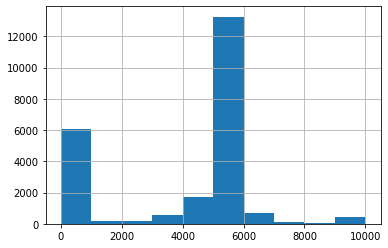

In [30]:
data.loc[data['TOTAL_DOSE'] > 20000, 'TOTAL_DOSE'] = np.NaN
data.loc[data['TOTAL_DOSE'] > 10000, 'TOTAL_DOSE'] = 10000
data['TOTAL_DOSE'].hist()

In [31]:
data['Radiation Dose, >30 Gy'] = np.NaN
data.loc[data['TOTAL_DOSE'] >= 3000, 'Radiation Dose, >30 Gy'] = 1
data.loc[data['TOTAL_DOSE'] < 3000, 'Radiation Dose, >30 Gy'] = 0

data['Radiation Dose, >30 Gy'].value_counts(dropna=False)


NaN    28496
1.0    16871
0.0     6429
Name: Radiation Dose, >30 Gy, dtype: int64

In [32]:
data_rad = data[data['Radiation Dose, >30 Gy'] == 1]
table(data_rad, 'APR')


,counts,percent
0.0,4746,0.930588
1.0,354,0.069412


In [33]:
pd.crosstab(data['APR'], data['Radiation Dose, >30 Gy'], margins=True, dropna=False, normalize=True)

"Radiation Dose, >30 Gy",0.0,1.0,All
APR,,,
0.0,0.384526,0.553018,0.933041
1.0,0.021207,0.041249,0.066959
All,0.275923,0.724077,1.000000


In [34]:
data['stage'] = np.NaN

In [35]:
'TNM_CLIN_T', 'TNM_CLIN_N', 'TNM_CLIN_M',
'TNM_CLIN_T', 'TNM_CLIN_N', 'TNM_CLIN_M', 'TNM_CLIN_STAGE_GROUP',
'AJCC_TNM_CLIN_M', 'AJCC_TNM_CLIN_N', 'AJCC_TNM_CLIN_N_SFX', 'AJCC_TNM_CLIN_STG_GRP', 'AJCC_TNM_CLIN_T',

('AJCC_TNM_CLIN_M',
 'AJCC_TNM_CLIN_N',
 'AJCC_TNM_CLIN_N_SFX',
 'AJCC_TNM_CLIN_STG_GRP',
 'AJCC_TNM_CLIN_T')

In [36]:
#if YEAR_OF_DIAGNOSIS is < 2018, stage is 'AJCC Clinical Stage Group'
data['stage'] = data['AJCC_TNM_CLIN_STG_GRP']
data.loc[data['YEAR_OF_DIAGNOSIS'] < 2018, 'stage'] = data.loc[data['YEAR_OF_DIAGNOSIS'] < 2018, 'TNM_CLIN_STAGE_GROUP']
#if 'stage' is still NaN, then fill with 'AJCC Clinical Stage Group'
data.loc[data['stage'].isnull(), 'stage'] = data.loc[data['stage'].isnull(), 'TNM_CLIN_STAGE_GROUP']
#find rows where 'stage' does not equal 'TNM_CLIN_STAGE_GROUP' and show only those columns
data.loc[(data['stage'] != data['TNM_CLIN_STAGE_GROUP']) & (data['stage'].notnull() & (data['TNM_CLIN_STAGE_GROUP'].notnull())), ['stage', 'TNM_CLIN_STAGE_GROUP']]
#find rows where 'stage' does not equal 'TNM_CLIN_STAGE_GROUP' and show only those columns
data.loc[(data['stage'] != data['TNM_CLIN_STAGE_GROUP']) & (data['stage'].notnull() & (data['TNM_CLIN_STAGE_GROUP'].notnull())), ['stage', 'TNM_CLIN_STAGE_GROUP']]

,stage,TNM_CLIN_STAGE_GROUP


In [37]:
data['stage'].value_counts()

2     15353
3B     9069
1      7053
3A     6329
4      2462
2A     2205
3C     1613
2B      667
0       647
3       198
88       35
Name: stage, dtype: int64

In [38]:
data['t_stage'] = data['TNM_CLIN_T']
data['n_stage'] = data['TNM_CLIN_N']
data['m_stage'] = data['TNM_CLIN_M']

data['t_stage'].value_counts(dropna=False)
#if YEAR_OF_DIAGNOSIS is >= 2018 and t_stage is null, T stage is 'AJCC_TNM_CLIN_T'
data.loc[((data['YEAR_OF_DIAGNOSIS'] >= 2018) & (data['t_stage'].isnull())), 't_stage'] = data.loc[((data['YEAR_OF_DIAGNOSIS'] >= 2018) & (data['t_stage'].isnull())), 'AJCC_TNM_CLIN_T']

#same for n and m stages
data.loc[((data['YEAR_OF_DIAGNOSIS'] >= 2018) & (data['n_stage'].isnull())), 'n_stage'] = data.loc[((data['YEAR_OF_DIAGNOSIS'] >= 2018) & (data['n_stage'].isnull())), 'AJCC_TNM_CLIN_N']
data.loc[((data['YEAR_OF_DIAGNOSIS'] >= 2018) & (data['m_stage'].isnull())), 'm_stage'] = data.loc[((data['YEAR_OF_DIAGNOSIS'] >= 2018) & (data['m_stage'].isnull())), 'AJCC_TNM_CLIN_M']
data['t_stage'].value_counts(dropna=False)
#if t_stage contains 'is' or 'x', t_stage is 0
data.loc[data['t_stage'].str.contains('is', na=False), 't_stage'] = 0
data.loc[data['t_stage'].str.contains('x', case=False, na=False), 't_stage'] = np.NaN
data.loc[data['t_stage'].str.contains('1', case=False, na=False), 't_stage'] = 1
data.loc[data['t_stage'].str.contains('2', case=False, na=False), 't_stage'] = 2
data.loc[data['t_stage'].str.contains('3', case=False, na=False), 't_stage'] = 3
data.loc[data['t_stage'].str.contains('4', case=False, na=False), 't_stage'] = 4
data.loc[data['t_stage'].str.contains('is', case=False, na=False), 't_stage'] = 0
data.loc[data['t_stage'].str.contains('0', case=False, na=False), 't_stage'] = 0
# data['t_stage'].fillna(0, inplace=True)
data['t_stage'].value_counts(dropna=False)
data['n_stage'].value_counts(dropna=False)
data.loc[data['n_stage'].str.contains('is', case=False, na=False), 'n_stage'] = 0
data.loc[data['n_stage'].str.contains('0', case=False, na=False), 'n_stage'] = 0
# data['n_stage'].fillna(0, inplace=True)
data.loc[data['n_stage'].str.contains('1', case=False, na=False), 'n_stage'] = 1
data.loc[data['n_stage'].str.contains('2', case=False, na=False), 'n_stage'] = 1
data.loc[data['n_stage'].str.contains('3', case=False, na=False), 'n_stage'] = 1
data.loc[data['n_stage'].str.contains('4', case=False, na=False), 'n_stage'] = 1
data.loc[data['n_stage'].str.contains('X', case=False, na=False), 'n_stage'] = np.NaN
data['n_stage'].value_counts(dropna=False)
data['m_stage'].value_counts(dropna=False)
data['m_stage'].fillna(0, inplace=True)
data.loc[data['m_stage'].str.contains('is', case=False, na=False), 'm_stage'] = 0
data.loc[data['m_stage'].str.contains('0', case=False, na=False), 'm_stage'] = 0
data.loc[data['m_stage'].str.contains('1', case=False, na=False), 'm_stage'] = 1
data.loc[data['m_stage'].str.contains('88', case=False, na=False), 'm_stage'] = 0
data.loc[data['m_stage'].str.contains('x', case=False, na=False), 'm_stage'] = 0
data['m_stage'].value_counts(dropna=False)


0    49351
1     2445
Name: m_stage, dtype: int64

In [39]:
before = data.shape[0]
data.loc[data['m_stage'] == 1, 'stage'] = 4
data = data.loc[data['m_stage'] == 0]
data = data.loc[data['stage'] != 4]
data = data.loc[data['stage'] != '4']
after = data.shape[0]
drop = before - after

drop_counts = drop_counts.append({'criteria': 'stage IV', 'before': before, 'after': after, 'drop': drop, '% APR': perc_APR(data)}, ignore_index=True)
drop_counts.head()

,criteria,before,after,drop,% APR
0,total,0,80128,0,0.194337
1,histology,80128,70610,9518,0.108838
2,no radiation,70610,51796,18814,0.066959
3,stage IV,51796,49284,2512,0.066505


In [40]:
table(data, 'APR')

,counts,percent
0.0,19286,0.933495
1.0,1374,0.066505


In [41]:
data.loc[data['AJCC_TNM_CLIN_N'].str.contains('cN1', case=False, na=False), 'stage'] = '3'
data.loc[data['TNM_CLIN_N'].str.contains('cN1', case=False, na=False), 'stage'] = '3'

In [42]:
#create a dataframe including only rows where 'stage' is null
data_stage_null = data.loc[data['stage'].isna()]
data_stage_null = data_stage_null.loc[data['APR'] == 1]
data_stage_null.shape

(361, 66)

In [43]:
tnm_cols = [col for col in data.columns if 'TNM' in col]
data.drop(tnm_cols, axis=1, inplace=True)

In [44]:
# data.loc[data['stage'] == '<NA>', 'stage'] = np.NaN
before = data.shape[0]
data = data[data['stage'] != '0']
after = data.shape[0]
drop = before - after

drop_counts = drop_counts.append({'criteria': 'stage 0', 'before': before, 'after': after, 'drop': drop, '% APR': perc_APR(data)}, ignore_index=True)
drop_counts.head()


,criteria,before,after,drop,% APR
0,total,0,80128,0,0.194337
1,histology,80128,70610,9518,0.108838
2,no radiation,70610,51796,18814,0.066959
3,stage IV,51796,49284,2512,0.066505
4,stage 0,49284,48640,644,0.066413


In [45]:
data.loc[data['stage'] == 3, 'stage'] = '3'
data['stage'].value_counts(dropna=False)

2      15348
3B      9020
1       7045
NaN     6034
3A      4725
3       3579
2A      2190
2B       656
88        35
3C         8
Name: stage, dtype: int64

In [46]:
#if the stage is 2 and t_stage is null, t_stage is 2
data.loc[(data['stage'] == '2') & (data['t_stage'].isna()), 't_stage'] = 2

#if the stage is 3 and t_stage is null, t_stage is 1
data.loc[(data['stage'] == '3') & (data['t_stage'].isna()), 't_stage'] = 1
#if the stage is 3 and n_stage is null, n_stage is 1
data.loc[(data['stage'] == '3') & (data['n_stage'].isna()) & (data['t_stage'] != 4), 'n_stage'] = 1


data.loc[(data['t_stage'] == 1) & (data['n_stage'] == 0), 'stage'] = '1'
data.loc[(data['t_stage'] == 2) & (data['n_stage'] == 0), 'stage'] = '2A'
data.loc[(data['t_stage'] == 2) & (data['n_stage'].isna()), 'stage'] = '2A'

data.loc[(data['t_stage'] == 3) & (data['n_stage'] == 0), 'stage'] = '2B'
data.loc[(data['t_stage'] == 3) & (data['n_stage'].isna()), 'stage'] = '2B'
data.loc[(data['t_stage'] == 0) & (data['n_stage'] == 1), 'stage'] = '3A'
data.loc[(data['t_stage'] == 1) & (data['n_stage'] == 1), 'stage'] = '3A'
data.loc[(data['t_stage'] == 2) & (data['n_stage'] == 1), 'stage'] = '3A'
data.loc[(data['t_stage'] == 4) & (data['n_stage'] == 0), 'stage'] = '3B'
data.loc[(data['t_stage'] == 3) & (data['n_stage'] == 1), 'stage'] = '3C'
data.loc[(data['t_stage'] == 4) & (data['n_stage'] == 1), 'stage'] = '3C'
data['stage'].value_counts(dropna=False)

2A     14390
3A      7793
3C      7530
1       6787
NaN     5555
2B      4529
3B      2006
88        35
2         11
3          4
Name: stage, dtype: int64

In [47]:
data_2 = data.loc[data['stage'] == 2]
pd.crosstab(data_2['t_stage'], data_2['n_stage'])

n_stage
t_stage


In [48]:
data.loc[(data['stage'] == '2') & (data['n_stage'] == 0) & (data['t_stage'] == 0), 'stage'] = '2A'
data.loc[data['stage'] == 2, 'stage'] = '2A'
data.loc[(data['stage'] == '3') & (data['n_stage'] == 0) & (data['t_stage'] == 0), 'stage'] = '3A'
data.loc[data['stage'] == 3, 'stage'] = '3A'

In [49]:
data['stage'].value_counts(dropna=False)

2A     14397
3A      7793
3C      7530
1       6787
NaN     5555
2B      4529
3B      2006
88        35
2          4
3          4
Name: stage, dtype: int64

In [50]:
# data_stage_null = data.loc[data['stage'].isna()]
# data_stage_null = data_stage_null.loc[data['APR'] == 1]
# data_stage_null = data_stage_null.loc[data['RX_SUMM_SURGRAD_SEQ'] == 2]
# data_stage_null.shape

In [51]:
# pd.crosstab(data_stage_null['t_stage'], data_stage_null['n_stage'])

In [52]:
# data_stage_null.loc[(data_stage_null['t_stage'] == 0) & (data_stage_null['n_stage'] == 0), 'stage'] = '0'
# data['stage'].update(data_stage_null['stage'])
# data['stage'].value_counts(dropna=False)

In [53]:
data.loc[data['stage'] == '<NA>', 'stage'] = np.NaN
before = data.shape[0]
data.loc[data['stage'] == '88', 'stage'] = np.NaN
data = data.dropna(subset=['stage'])

after = data.shape[0]
drop = before - after

drop_counts = drop_counts.append({'criteria': 'stage missing', 'before': before, 'after': after, 'drop': drop, '% APR': perc_APR(data)}, ignore_index=True)
drop_counts.head(10)


,criteria,before,after,drop,% APR
0,total,0,80128,0,0.194337
1,histology,80128,70610,9518,0.108838
2,no radiation,70610,51796,18814,0.066959
3,stage IV,51796,49284,2512,0.066505
4,stage 0,49284,48640,644,0.066413
5,stage missing,48640,43050,5590,0.053483


In [54]:
by_stage(data, 'APR')

APR,0.0,1.0,total
stage,,,
1,2462 (98.0%),56 (2.0%),6787
2,3 (100.0%),0 (0.0%),4
2A,6677 (97.0%),239 (3.0%),14397
2B,1917 (91.0%),190 (9.0%),4529
3A,3361 (96.0%),137 (4.0%),7793
3B,788 (90.0%),90 (10.0%),2006
3C,2755 (90.0%),303 (10.0%),7530


In [60]:
data['def_interval'] = data['DX_DEFSURG_STARTED_DAYS'] - data['DX_SURG_STARTED_DAYS']
data['def_interval'].describe()

count    10289.000000
mean         4.428127
std         30.332414
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        737.000000
Name: def_interval, dtype: float64

<AxesSubplot:>

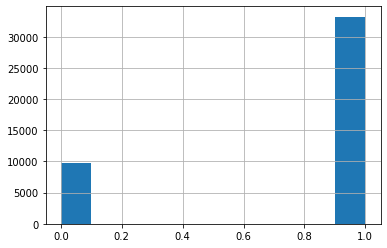

In [61]:
data.loc[data['def_interval'] != 0, 'def_interval'] = 1
data['def_interval'].hist()

In [63]:
pd.crosstab(data['def_interval'], data['APR'])

APR,0.0,1.0
def_interval,,
0.0,0,870
1.0,17963,145


<AxesSubplot:>

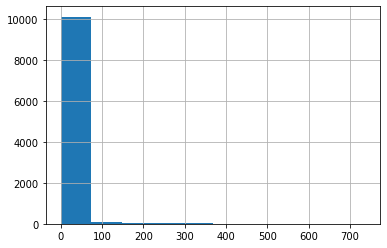

In [58]:
data['def_interval'].hist()

In [47]:
before = data.shape[0]
data = data.dropna(subset=['APR'])
after = data.shape[0]
drop = before - after
drop_counts = drop_counts.append({'criteria': 'f/u missing', 'before': before, 'after': after, 'drop': drop, '% APR': perc_APR(data)}, ignore_index=True)
drop_counts.head(10)

,criteria,before,after,drop,% APR
0,total,0,80128,0,0.194337
1,histology,80128,70610,9518,0.108838
2,no radiation,70610,51796,18814,0.066959
3,stage IV,51796,49284,2512,0.066505
4,stage 0,49284,48640,644,0.066413
5,stage missing,48640,43050,5590,0.053483
6,f/u missing,43050,18978,24072,0.053483


In [97]:
table(data, 'APR')

,counts,percent
0.0,17963,0.946517
1.0,1015,0.053483


In [48]:
drop_counts.to_csv('results/drop_counts.csv', index=False)

In [49]:
by_stage(data, 'APR')

APR,0.0,1.0,total
stage,,,
1,2462 (98.0%),56 (2.0%),2518
2,3 (100.0%),0 (0.0%),3
2A,6677 (97.0%),239 (3.0%),6916
2B,1917 (91.0%),190 (9.0%),2107
3A,3361 (96.0%),137 (4.0%),3498
3B,788 (90.0%),90 (10.0%),878
3C,2755 (90.0%),303 (10.0%),3058


<AxesSubplot:>

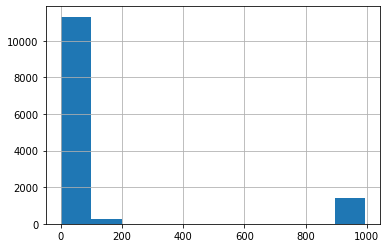

In [50]:
data['TUMOR_SIZE'].hist()

In [51]:
table(data, 'APR')

,counts,percent
0.0,17963,0.946517
1.0,1015,0.053483


<AxesSubplot:>

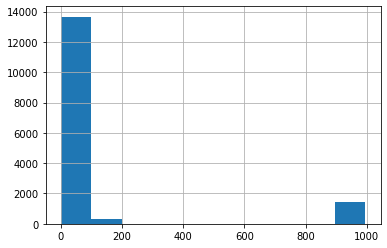

In [52]:
#if TUMOR_SIZE is missing, fill with TUMOR_SIZE_SUMMARY_2016
data.loc[data['TUMOR_SIZE'].isnull(), 'TUMOR_SIZE'] = data.loc[data['TUMOR_SIZE'].isnull(), 'TUMOR_SIZE_SUMMARY_2016']
data['TUMOR_SIZE'].hist()


<AxesSubplot:>

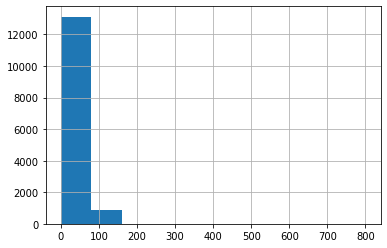

In [53]:
data.loc[data['TUMOR_SIZE'] > 800, 'TUMOR_SIZE'] = np.NaN
data['TUMOR_SIZE'].hist()


<AxesSubplot:>

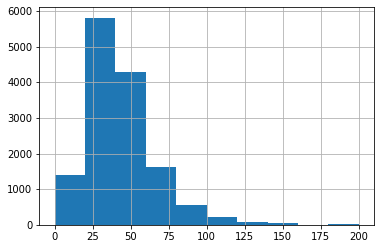

In [54]:
data.loc[data['TUMOR_SIZE'] > 200, 'TUMOR_SIZE'] = 200
data['TUMOR_SIZE'].hist()

In [55]:
data.drop('TUMOR_SIZE_SUMMARY_2016', axis=1, inplace=True)

In [56]:
table(data, 'APR')

,counts,percent
0.0,17963,0.946517
1.0,1015,0.053483


In [57]:
data_tumor_size = data[data['TUMOR_SIZE'].notnull()]
table(data_tumor_size, 'APR')

,counts,percent
0.0,13196,0.940288
1.0,838,0.059712


In [58]:
data.shape

(18978, 44)

<AxesSubplot:>

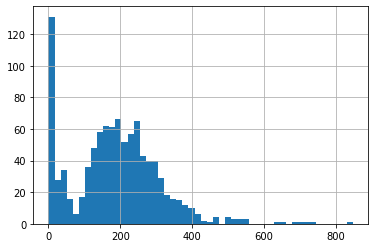

In [59]:
#find the distribution of days between diagnosis and surgery
data['DX_SURG_STARTED_DAYS'].hist(bins=50)

In [60]:
data['DX_SURG_STARTED_DAYS'].quantile(0.9)

327.0

<AxesSubplot:>

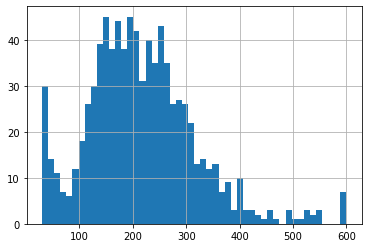

In [61]:
data.loc[data['DX_SURG_STARTED_DAYS'] <30, 'DX_SURG_STARTED_DAYS'] = np.NaN
data.loc[data['DX_SURG_STARTED_DAYS'] > 600, 'DX_SURG_STARTED_DAYS'] = 600

data['DX_SURG_STARTED_DAYS'].hist(bins=50)

In [62]:
data['rad_end'] = data['RAD_ELAPSED_RX_DAYS'] + data['DX_RAD_STARTED_DAYS']

<AxesSubplot:>

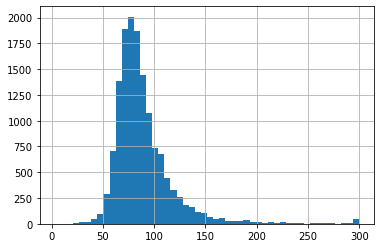

In [63]:
data.loc[data['rad_end'] > 300, 'rad_end'] = 300
data['rad_end'].hist(bins=50)

<AxesSubplot:>

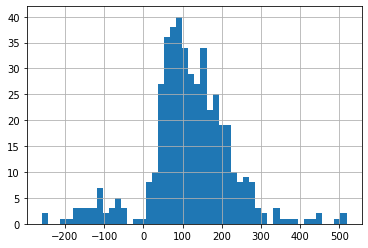

In [64]:
data['surg_rad_days'] = data['DX_SURG_STARTED_DAYS'] - data['rad_end']
data['surg_rad_days'].hist(bins=50)

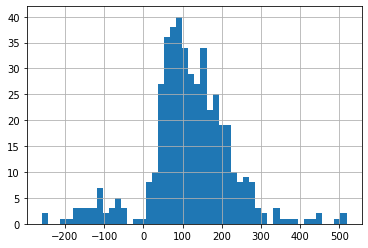

In [65]:
data_apr = data[data['APR'] == 1]
data_apr['surg_rad_days'].hist(bins=50)
#save the figure
plt.savefig('results/surg_rad_days.png', bbox_inches='tight')

In [66]:
data.drop(columns=['surg_rad_days', 'rad_end'], inplace=True)

<AxesSubplot:>

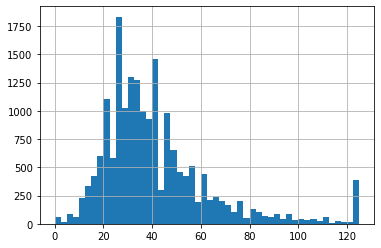

In [67]:
data.loc[data['DX_RAD_STARTED_DAYS'] > 700, 'DX_RAD_STARTED_DAYS'] = np.NaN
data.loc[data['DX_RAD_STARTED_DAYS'] > 125, 'DX_RAD_STARTED_DAYS'] = 125
data['DX_RAD_STARTED_DAYS'].hist(bins=50)

<AxesSubplot:>

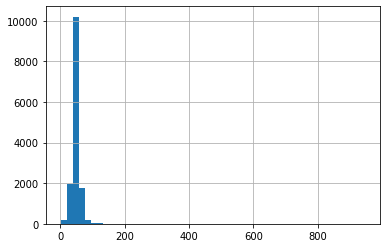

In [68]:
data['RAD_ELAPSED_RX_DAYS'].hist(bins=50)

<AxesSubplot:>

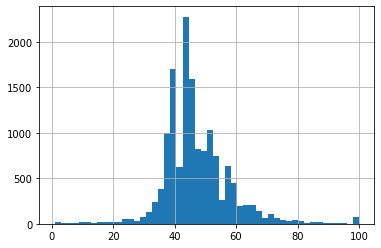

In [69]:
data.loc[data['RAD_ELAPSED_RX_DAYS'] > 700, 'RAD_ELAPSED_RX_DAYS'] = np.NaN
data.loc[data['RAD_ELAPSED_RX_DAYS'] > 100, 'RAD_ELAPSED_RX_DAYS'] = 100
data['RAD_ELAPSED_RX_DAYS'].hist(bins=50)

In [70]:
rad_cols = ['RAD_LOCATION_OF_RX', 'REASON_FOR_NO_RADIATION', 'RX_SUMM_SURGRAD_SEQ']

chemo_cols = ['DX_CHEMO_STARTED_DAYS', 'RX_SUMM_SYSTEMIC_SUR_SEQ']

surg_cols = ['PALLIATIVE_CARE', 'DX_SURG_STARTED_DAYS', 'RX_SUMM_SURG_PRIM_SITE', 'RX_SUMM_SURGICAL_MARGINS', 'SURG_DISCHARGE_DAYS', 'READM_HOSP_30_DAYS', 'REASON_FOR_NO_SURGERY']

In [71]:
#drop all columns related to the treatment
for x in rad_cols:
    try:
        data.drop(x, axis=1, inplace=True)
    except KeyError:
        pass
for x in surg_cols:
    try:
        data.drop(x, axis=1, inplace=True)
    except KeyError:
        pass
for x in os_cols:
    try:
        data.drop(x, axis=1, inplace=True)
    except KeyError:
        pass
for x in chemo_cols:
    try:
        data.drop(x, axis=1, inplace=True)
    except KeyError:
        pass

In [72]:
#find the columns with the greatest proportion of missing values
missing_values = data.isnull().sum()
pd.DataFrame(missing_values.sort_values(ascending=False)).head(20)


,0
GRADE_CLIN,18632
"Radiation Dose, >30 Gy",11170
TOTAL_DOSE,11170
LYMPH_VASCULAR_INVASION,5946
TUMOR_SIZE,4944
RAD_ELAPSED_RX_DAYS,4569
MED_INC_QUAR_2016,2060
NO_HSD_QUAR_2016,2030
CROWFLY,1834
UR_CD_13,530


In [73]:
data['GRADE'].value_counts(dropna=False)

2.0    6201
9.0    5931
3.0    5223
1.0    1167
NaN     346
4.0     110
Name: GRADE, dtype: int64

In [74]:
data['GRADE'] = data['GRADE'].astype(str)
data['GRADE_CLIN'] = data['GRADE_CLIN'].astype(str)
data.loc[data['GRADE'] == 'nan', 'GRADE'] = data.loc[data['GRADE'] == 'nan', 'GRADE_CLIN']
data.loc[data['GRADE'].str.contains('1'), 'GRADE'] = '1.0'
data.loc[data['GRADE'].str.contains('2'), 'GRADE'] = '2.0'
data.loc[data['GRADE'].str.contains('3'), 'GRADE'] = '3.0'
data.loc[data['GRADE'].str.contains('4'), 'GRADE'] = '4.0'
data['GRADE'].value_counts(dropna=False)


2.0    6324
9.0    5931
3.0    5294
1.0    1196
9       116
4.0     110
H         7
Name: GRADE, dtype: int64

In [75]:
drop = ['GRADE_CLIN']
data.drop(drop, axis=1, inplace=True)

In [76]:
len(data['YEAR_OF_DIAGNOSIS'].unique())

16

In [77]:
facility_by_year = pd.DataFrame(pd.crosstab(data['PUF_FACILITY_ID'], data['YEAR_OF_DIAGNOSIS'], margins=True))
facility_counts = pd.DataFrame(facility_by_year['All'])
#drop the last row, which is the total
facility_counts.drop(facility_counts.tail(1).index, inplace=True)

In [78]:
facility_by_year = pd.DataFrame(pd.crosstab(data['PUF_FACILITY_ID'], data['YEAR_OF_DIAGNOSIS']))
facility_by_year['num_zero'] = 1000
for i,row in facility_by_year.iterrows():
    try:
        row['num_zero'] = pd.DataFrame(facility_by_year.loc[i].value_counts()).loc[0][0]
    except KeyError:
        row['num_zero'] = 0

In [79]:
facility_by_year['num_zero'] = 16 - facility_by_year['num_zero']

facility_by_year.head()

YEAR_OF_DIAGNOSIS,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,num_zero
PUF_FACILITY_ID,,,,,,,,,,,,,,,,,
ABZFZYJZCA,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2
ADSHBUUWZC,0,0,1,0,2,1,2,2,1,2,0,0,1,0,0,0,8
ADXGCKXJNR,0,0,0,0,0,0,0,4,2,5,3,3,2,5,0,0,7
ADXQMZWWTZ,0,1,1,1,2,0,1,0,0,3,1,0,0,0,1,0,8
AEFZNJSMJI,1,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,3


In [80]:
facility_counts['num_zero'] = facility_by_year['num_zero']
facility_counts.head()

,All,num_zero
PUF_FACILITY_ID,,
ABZFZYJZCA,2,2
ADSHBUUWZC,12,8
ADXGCKXJNR,24,7
ADXQMZWWTZ,11,8
AEFZNJSMJI,4,3


In [81]:
facility_counts['norm'] = facility_counts['All'] / facility_counts['num_zero']
facility_counts.head()

,All,num_zero,norm
PUF_FACILITY_ID,,,
ABZFZYJZCA,2,2,1.000000
ADSHBUUWZC,12,8,1.500000
ADXGCKXJNR,24,7,3.428571
ADXQMZWWTZ,11,8,1.375000
AEFZNJSMJI,4,3,1.333333


In [82]:
facility_counts['norm'].describe()

count    1224.000000
mean        1.826100
std         1.072992
min         1.000000
25%         1.200000
50%         1.500000
75%         2.071429
max        18.000000
Name: norm, dtype: float64

In [83]:
fac_ids = facility_counts.index.to_list()
len(fac_ids)

1224

In [84]:
fac_ids1 = fac_ids[:len(fac_ids)//4]
fac_ids2 = fac_ids[(len(fac_ids)//4):((len(fac_ids)//4)*2)]
fac_ids3 = fac_ids[((len(fac_ids)//4) * 2):((len(fac_ids)//4)*3)]
fac_ids4 = fac_ids[((len(fac_ids)//4) * 3):]

data['facs_quart_norm'] = np.NaN
data.loc[data['PUF_FACILITY_ID'].isin(fac_ids1), 'facs_quart_norm'] = 1
data.loc[data['PUF_FACILITY_ID'].isin(fac_ids2), 'facs_quart_norm'] = 2
data.loc[data['PUF_FACILITY_ID'].isin(fac_ids3), 'facs_quart_norm'] = 3
data.loc[data['PUF_FACILITY_ID'].isin(fac_ids4), 'facs_quart_norm'] = 4
data['facs_quart_norm'].value_counts(dropna=False)

4.0    5232
3.0    4700
1.0    4649
2.0    4397
Name: facs_quart_norm, dtype: int64

In [85]:
facs = pd.DataFrame(data['PUF_FACILITY_ID'].value_counts()).index.to_list()
len(facs)

1224

In [86]:
facs1 = facs[:len(facs)//4]
facs2 = facs[(len(facs)//4):((len(facs)//4)*2)]
facs3 = facs[((len(facs)//4) * 2):((len(facs)//4)*3)]
facs4 = facs[((len(facs)//4) * 3):]

data['facs_quart'] = np.NaN
data.loc[data['PUF_FACILITY_ID'].isin(facs1), 'facs_quart'] = 1
data.loc[data['PUF_FACILITY_ID'].isin(facs2), 'facs_quart'] = 2
data.loc[data['PUF_FACILITY_ID'].isin(facs3), 'facs_quart'] = 3
data.loc[data['PUF_FACILITY_ID'].isin(facs4), 'facs_quart'] = 4
data['facs_quart'].value_counts(dropna=False)

1.0    11381
2.0     4525
3.0     2281
4.0      791
Name: facs_quart, dtype: int64

In [87]:
corr = data['facs_quart'].corr(data['APR'])
corr_norm = data['facs_quart_norm'].corr(data['APR'])
print(corr, corr_norm)

0.0244240240156557 -0.00647317970692248


In [88]:
data.drop(['facs_quart_norm'], axis=1, inplace=True)

In [89]:
data.drop('PUF_FACILITY_ID', axis=1, inplace=True)

In [90]:
#find columns with data type object
cat_cols = data.select_dtypes(include=['object']).columns.to_list()
cat_cols

['PUF_CASE_ID', 'GRADE', 'stage', 't_stage', 'n_stage', 'm_stage']

In [91]:
data.set_index('PUF_CASE_ID', inplace=True)

In [92]:
cat_cols.remove('PUF_CASE_ID')
data.head()

,FACILITY_TYPE_CD,FACILITY_LOCATION_CD,AGE,SEX,RACE,SPANISH_HISPANIC_ORIGIN,INSURANCE_STATUS,UR_CD_13,CROWFLY,CDCC_TOTAL_BEST,...,MED_INC_QUAR_2016,PUF_MEDICAID_EXPN_CODE,TOTAL_DOSE,APR,"Radiation Dose, >30 Gy",stage,t_stage,n_stage,m_stage,facs_quart
PUF_CASE_ID,,,,,,,,,,,,,,,,,,,,,
D66f458f9-bdc0-4c95-94a3-a5f8c5bb74f9,3.0,5.0,52,2,1.0,0,0,2.0,3.6,0,...,1.0,0,0.0,0.0,0.0,2A,2,0,0,1.0
Dfc68ea23-71aa-4b0d-87c0-587b4ce13d04,3.0,9.0,49,2,1.0,0,1,1.0,11.4,0,...,3.0,2,NaN,0.0,NaN,3A,2,1,0,1.0
D7a846888-d7d5-42ab-bd7f-8dd4e268adba,2.0,3.0,88,2,1.0,0,3,4.0,32.0,0,...,1.0,0,NaN,0.0,NaN,2B,3,0,0,3.0
D6a94c44a-86b9-4b34-8f6b-bcc0da65cc59,4.0,9.0,53,2,1.0,0,3,5.0,NaN,3,...,NaN,2,NaN,0.0,NaN,2B,3,0,0,1.0
D9733f795-06f9-44bd-a94c-cfff0110c969,1.0,7.0,53,2,1.0,0,1,3.0,3.9,0,...,3.0,3,5400.0,0.0,1.0,3C,3,1,0,4.0


In [93]:
data.shape

(18978, 29)

In [94]:
data.to_csv('data/table1_data.csv', index_label='Case Key')
